In [294]:
import json
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import random
import numpy as np
from scipy.interpolate import make_interp_spline

In [301]:
def get_raw_data(personalised=False):
    """
    Read .json files and append data to a dict with a key of sessions
    """
    data = {'sessions': []}
    if personalised:
        datadir = "./personalised_data/"
    else:
        datadir = "./data/"

    files = [fname for fname in os.listdir(datadir) if fname.endswith('.json')]
    
    for file in files:
        with open(f"{datadir}{file}", "r") as f:
            js = json.load(f)
            data['sessions'].extend(js['sessions'])
    
    return data

In [302]:
def what_commands(fname):
    """
    Return which commands were prompted in a given file (session)
    """
    with open (fname, "r") as f:
        js = json.load(f)
        commands = [entry['command'] for entry in js['sessions']]
    return commands

In [303]:
def organize_by_command(data):
    """
    Return a dict where key->command, value->list of list of keystrokes
    """
    commands = defaultdict(list)
    for session in data['sessions']:
        command = session['command']
        keystrokes = session['keystrokes']
        if len(keystrokes) == 0 or len(keystrokes) < len(command):
               continue
        commands[command].append(keystrokes)
    return commands

In [304]:
def zero_first(data):
    """
    Set latency of the first keystroke to zero.
    """
    for cmd in data.keys():
        for session in data[cmd]:
            session[0]['latency'] = 0
    return data

In [305]:
def get_prepared_data(personalised=False):
    """
    Return ordered, zeroed, data dictionary.
    """
    data = get_raw_data(personalised)
    organised = organize_by_command(data)
    zeroed = zero_first(organised)
    return zeroed

In [306]:
cmds = get_prepared_data(True)

In [324]:
def combine_common_tokens(dataset):
    """
    Certain keywords are reused in the dataset. We can combine them for increased coverage.
    i.e. sudo, install, apt, service, etc.
    """
    # We could make this selection automatic via a hashmap, but the idea is that
    # only certain keywords play a big enough role- especially for sudo, which will be an optional
    # prefix for commands to be considered.
    # If we went for all words, then we might as well draw the line at keypair latencies, which is not ideal.
    common_tokens = set(["sudo", "install", "service", "pacman", "systemctl"])
    aggregated_data = defaultdict(list)

    for command, sessions in dataset.items():
        splices = command.split()
        indices = [0]
        
        # Accumulate indices positions
        for i in range(1, len(splices)):
            indices.append(indices[-1] + len(splices[i-1]) + 1)  # Account for spaces

        for i, word in enumerate(splices):
            if word in common_tokens:
                start_idx = indices[i]
                end_idx = start_idx + len(word)  # Not including the space after the word

                # Extract the keystrokes corresponding to the word
                keystrokes = [session[start_idx:end_idx] for session in sessions]
                
                # Optionally nullify the first latency in each session to normalize start time
                for keystroke in keystrokes:
                    if keystroke:  # Ensure it's not an empty list
                        keystroke[0]['latency'] = 0

                aggregated_data[word].extend(keystrokes)

        # Add the full command data
        aggregated_data[command].extend(sessions)

    return aggregated_data

In [287]:
combine_common_tokens(handle_backspaces(get_prepared_data()))

defaultdict(list,
            {'pwd': [[{'key': 'p', 'latency': 0},
               {'key': 'w', 'latency': 104},
               {'key': 'd', 'latency': 61},
               {'key': 'Return', 'latency': 87}],
              [{'key': 'p', 'latency': 0},
               {'key': 'w', 'latency': 87},
               {'key': 'd', 'latency': 147},
               {'key': 'Return', 'latency': 107}],
              [{'key': 'p', 'latency': 0},
               {'key': 'w', 'latency': 38},
               {'key': 'd', 'latency': 93},
               {'key': 'Return', 'latency': 54}],
              [{'key': 'p', 'latency': 0},
               {'key': 'w', 'latency': 75},
               {'key': 'd', 'latency': 148},
               {'key': 'Return', 'latency': 139}]],
             'sudo': [[{'key': 's', 'latency': 0},
               {'key': 'u', 'latency': 94},
               {'key': 'd', 'latency': 113},
               {'key': 'o', 'latency': 83}],
              [{'key': 's', 'latency': 0},
               {'

In [325]:
cmds = combine_common_tokens(handle_backspaces(get_prepared_data(True)))

In [326]:
[i for i in cmds if len(cmds[i]) >= 2]

['exit',
 'sudo',
 'sudo su',
 'iptables -S',
 'sudo apt update',
 'cat /etc/resolv.conf',
 'cat /etc/hosts',
 'ping -c 1 9.9.9.9',
 'ifconfig',
 'systemctl',
 'systemctl start ',
 'curl http://',
 'uptime',
 'systemctl stop ',
 'mv * ../',
 'systemctl status ',
 'cat /etc/passwd',
 'rm -rf /tmp/*',
 'wget https://',
 'systemctl restart ',
 'id',
 'df -hT /',
 'tar --help',
 'cd',
 'tail /var/log/syslog',
 'whoami',
 'sudo apt upgrade ',
 'iptables -L',
 'touch ']

In [310]:
def plot_command_latencies(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))
    
    for sequence in keystroke_sequences:
        latencies = [keystroke['latency'] for keystroke in sequence]
        plt.plot(latencies, marker='o', linestyle='-')

    plt.title(f'Latencies for Command: {command}')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend([f'Session {i+1}' for i in range(len(keystroke_sequences))], loc='upper right')
    plt.grid(True)
    plt.show()

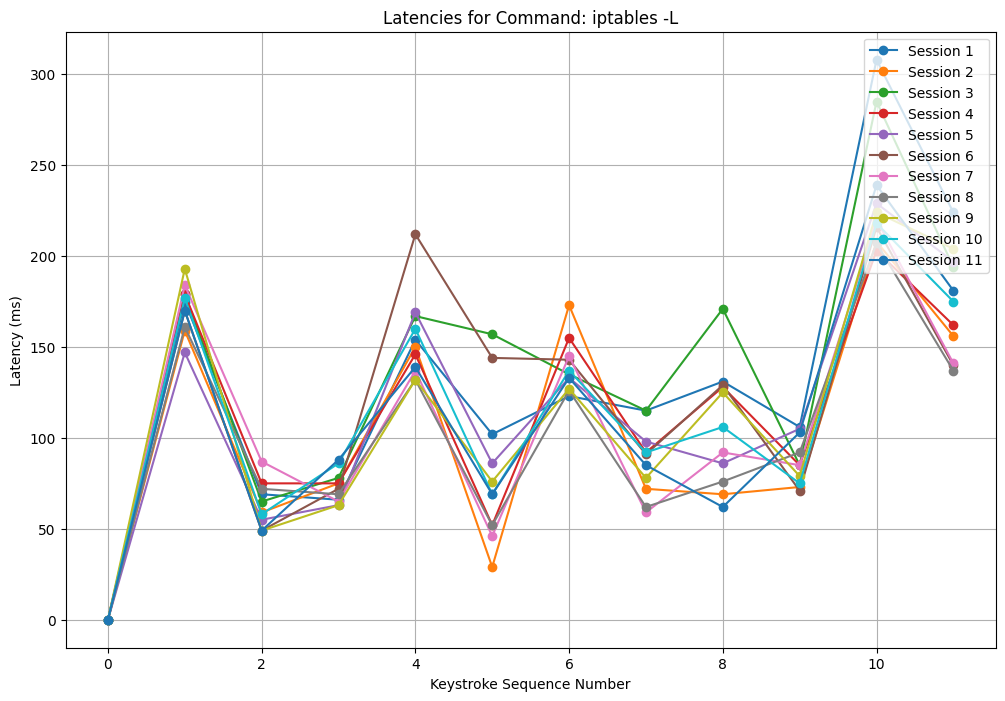

In [314]:
command = 'iptables -L'
plot_command_latencies(cmds[command], command)

In [14]:
cmds['ifconfig'][2]

[{'key': 'i', 'latency': 0},
 {'key': 'd', 'latency': 250},
 {'key': 'Backspace', 'latency': 263},
 {'key': 'f', 'latency': 86},
 {'key': 'c', 'latency': 135},
 {'key': 'o', 'latency': 125},
 {'key': 'n', 'latency': 198},
 {'key': 'f', 'latency': 107},
 {'key': 'i', 'latency': 108},
 {'key': 'g', 'latency': 108},
 {'key': 'Return', 'latency': 108}]

In [315]:
def handle_backspaces(keystroke_sequences):
    for command in keystroke_sequences.keys():
        for sequence in keystroke_sequences[command]:
            i = 0
            while i < len(sequence)-1:
                if sequence[i]['key'] == 'Backspace':
                    curr = sequence[i]
                    prev = sequence[i-1]
                    if i != 0:
                        sequence.remove(prev)
                        sequence.remove(curr)
                        i -= 1
                        continue
                    else:
                        sequence.remove(curr)
                        sequence[i+1]['latency'] = 0
                        continue
                i += 1
    return keystroke_sequences

In [316]:
cmds = handle_backspaces(cmds)

In [317]:
def plot_command_latencies(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))
    
    for sequence_idx, sequence in enumerate(keystroke_sequences):
        normal_keys_x = []
        normal_keys_y = []
        backspace_keys_x = []
        backspace_keys_y = []
        
        for keystroke_idx, keystroke in enumerate(sequence):
            if keystroke['key'] == 'Backspace':
                backspace_keys_x.append(keystroke_idx)
                backspace_keys_y.append(keystroke['latency'])
            normal_keys_x.append(keystroke_idx)
            normal_keys_y.append(keystroke['latency'])
                
        # Plot normal keystrokes
        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session {sequence_idx + 1} Keystrokes', zorder=1)
        # Plot Backspace keystrokes
        plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session {sequence_idx + 1} Backspaces', zorder=2)

    plt.title(f'Latencies for Command: {command}')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


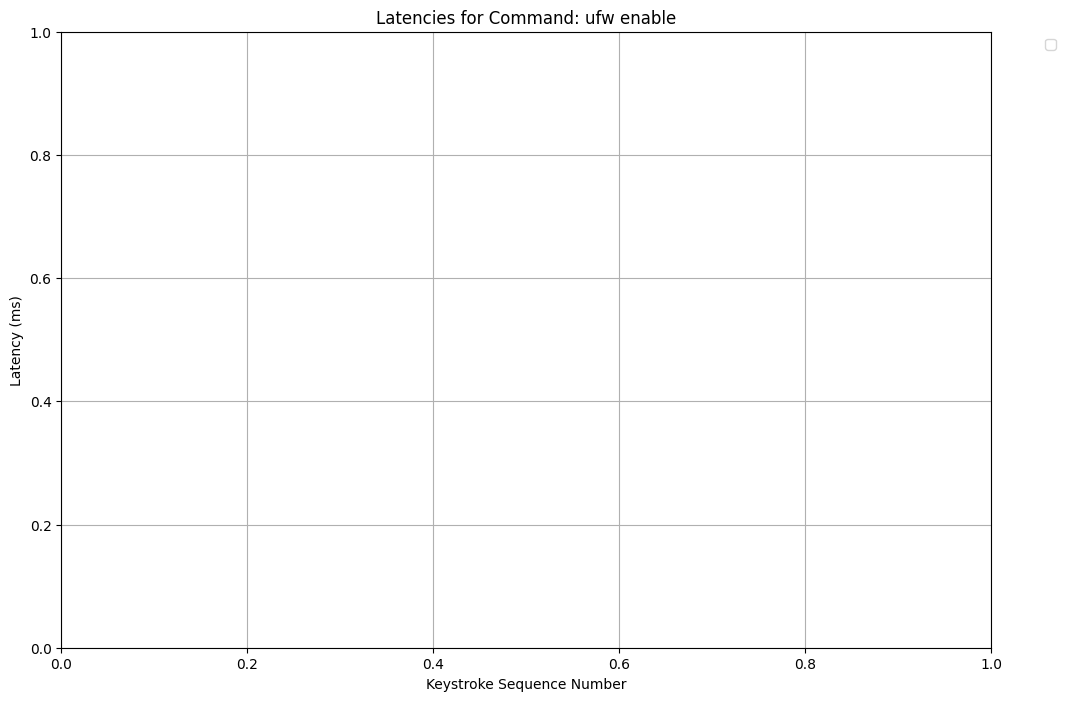

In [318]:
command = "ufw enable"
plot_command_latencies(cmds[command], command)

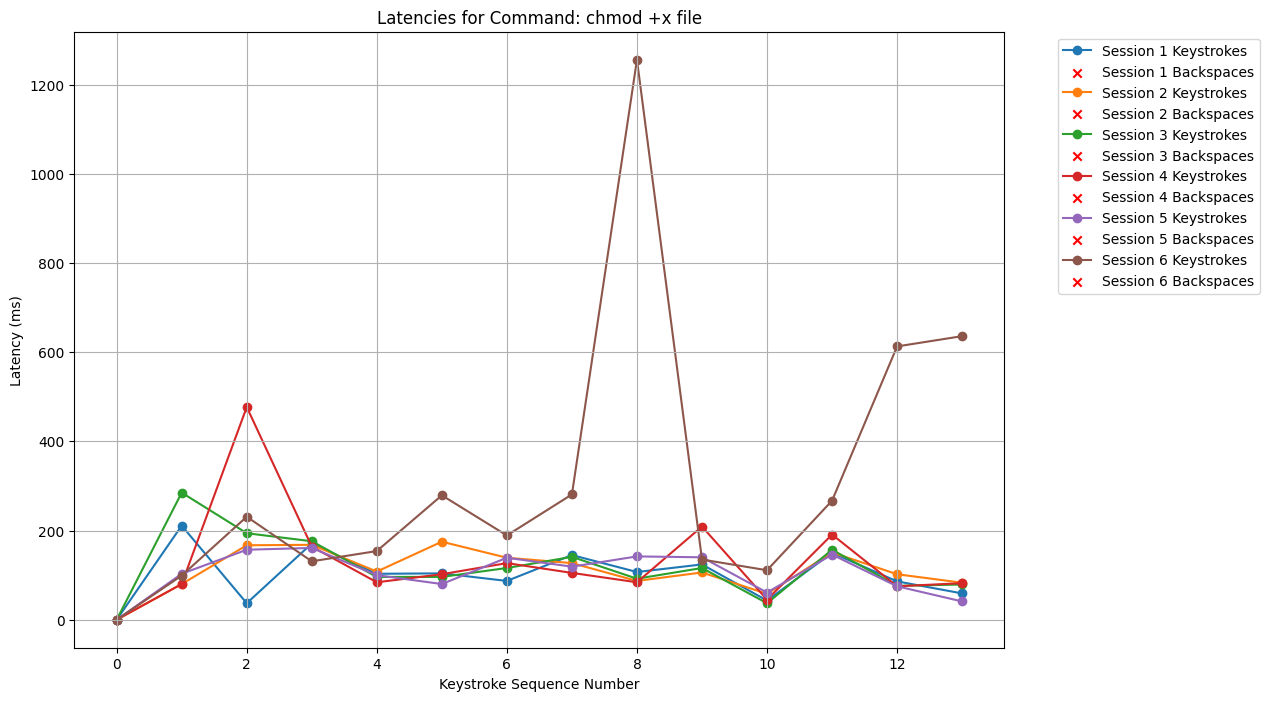

In [22]:
command = random.choice(list(cmds.keys()))
plot_command_latencies(cmds[command], command)

In [171]:
cmds['du -h directory'][3]

[{'key': 'd', 'latency': 0},
 {'key': 'u', 'latency': 68},
 {'key': ' ', 'latency': 107},
 {'key': '-', 'latency': 174},
 {'key': 'h', 'latency': 160},
 {'key': ' ', 'latency': 82},
 {'key': 'd', 'latency': 228},
 {'key': 'i', 'latency': 91},
 {'key': 'r', 'latency': 103},
 {'key': 'e', 'latency': 81},
 {'key': 'c', 'latency': 170},
 {'key': 'y', 'latency': 208},
 {'key': 't', 'latency': 22},
 {'key': 'o', 'latency': 72},
 {'key': 'Backspace', 'latency': 273},
 {'key': 'Backspace', 'latency': 125},
 {'key': 'Backspace', 'latency': 126},
 {'key': 'y', 'latency': 181},
 {'key': 'Backspace', 'latency': 417},
 {'key': 't', 'latency': 73},
 {'key': 'o', 'latency': 92},
 {'key': 'r', 'latency': 59},
 {'key': 'y', 'latency': 67},
 {'key': 'Return', 'latency': 213}]

In [387]:
def plot_command_distribution(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))

    total_latencies = [0] * (len(command) + 1)
    count_per_position = [0] * (len(command) + 1)

    # Plot each keystroke sequence
    for sequence in keystroke_sequences:
        normal_keys_x = []
        normal_keys_y = []
        
        for idx, keystroke in enumerate(sequence):
            normal_keys_x.append(idx)
            normal_keys_y.append(keystroke['latency'])
            if idx < len(total_latencies):
                total_latencies[idx] += keystroke['latency']
                count_per_position[idx] += 1

        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', color='blue', alpha=0.3, zorder=1)
    
    # Calculate mean latencies
    means = [total_latencies[i] / count_per_position[i] if count_per_position[i] else 0 for i in range(len(command)+1)]
    x_new = np.linspace(0, len(command), 300)  # 300 represents number of points to make between T.min and T.max

    # Smoothing the line
    spl = make_interp_spline(range(len(command)+1), means, k=3)  # BSpline object
    y_smooth = spl(x_new)

    plt.plot(x_new, y_smooth, marker='', linestyle='-', label='Mean keystroke latency', color='red', linewidth=2, zorder=2)

    plt.title(f'Mean latencies for command: "{command}"')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()

In [365]:
cmds = combine_common_tokens(handle_backspaces(get_prepared_data(True)))

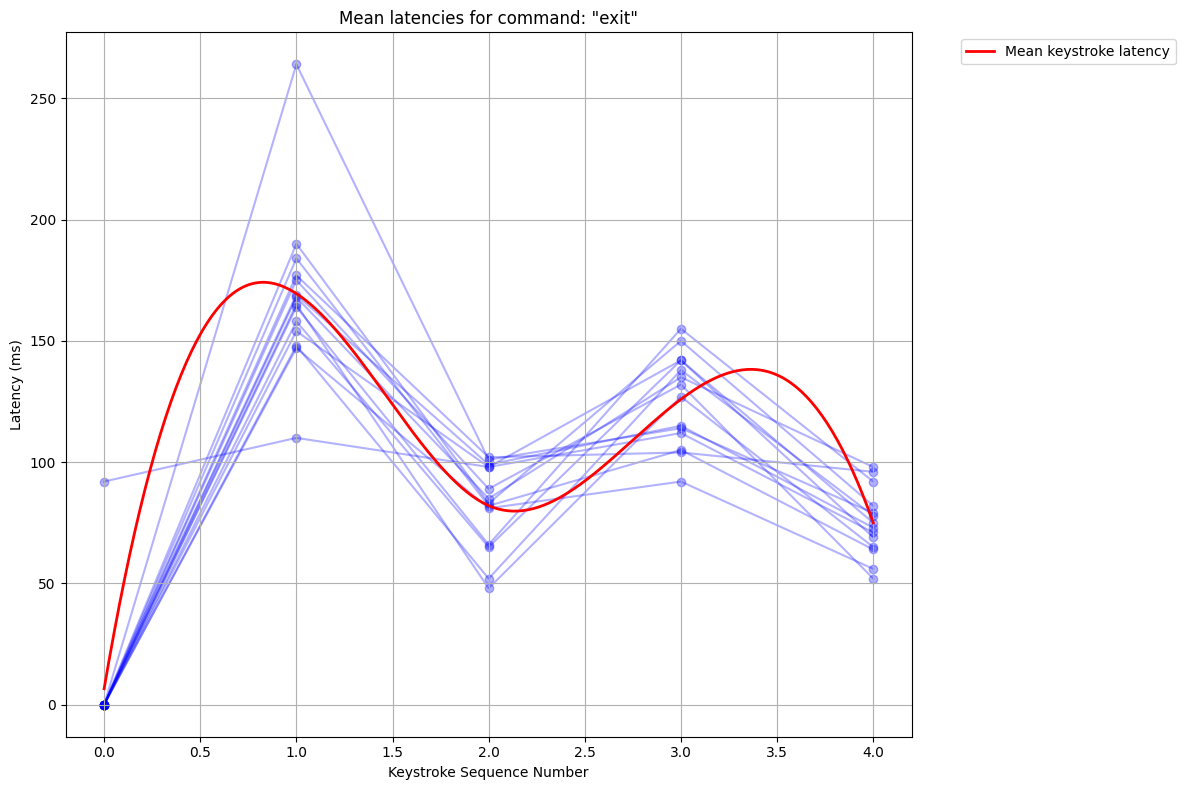

In [366]:
command = 'exit'
plot_command_distribution(cmds[command], command)

In [368]:
def load_ssh_data(path):
    with open(path, "r") as f:
        data = json.loads(f.read())
    return data

In [369]:
def convert_latencies(ssh_data):
    for sequence in ssh_data:
        for keystroke in sequence:
            keystroke['timestamp'] = keystroke['timestamp'] / 1000
    return ssh_data

In [370]:
ssh_data = convert_latencies(load_ssh_data("./sshniff_output/keystrokes.json"))

In [371]:
ssh_data[0]

[{'k_type': 'Keystroke', 'timestamp': 0.0, 'response_size': None, 'seq': 2602},
 {'k_type': 'Keystroke',
  'timestamp': 224.186,
  'response_size': None,
  'seq': 2638},
 {'k_type': 'Keystroke',
  'timestamp': 144.008,
  'response_size': None,
  'seq': 2674},
 {'k_type': 'Keystroke',
  'timestamp': 103.813,
  'response_size': None,
  'seq': 2710},
 {'k_type': 'Keystroke',
  'timestamp': 167.979,
  'response_size': None,
  'seq': 2746},
 {'k_type': 'Keystroke',
  'timestamp': 120.27,
  'response_size': None,
  'seq': 2782},
 {'k_type': 'Enter', 'timestamp': 1823.813, 'response_size': 304, 'seq': 2854}]

In [372]:
def plot_ssh_data(sequence):
    plt.figure(figsize=(12, 8))
    normal_keys_x = []
    normal_keys_y = []
    backspace_keys_x = []
    backspace_keys_y = []
    enter_keys_x = []
    enter_keys_y = []

    for keystroke_idx, keystroke in enumerate(sequence):
        if keystroke['k_type'] == 'Delete':
            backspace_keys_x.append(keystroke_idx)
            backspace_keys_y.append(keystroke['timestamp'])
        elif keystroke['k_type'] == 'Enter':
            enter_keys_x.append(keystroke_idx)
            enter_keys_y.append(keystroke['timestamp'])
        normal_keys_x.append(keystroke_idx)
        normal_keys_y.append(keystroke['timestamp'])
                
    # Plot normal keystrokes
    plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session 1 Keystrokes', zorder=1)
    # Plot Backspace keystrokes
    plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session 1 Backspaces', zorder=2)
    plt.scatter(enter_keys_x, enter_keys_y, color='green', marker='x', label=f'Session 1 Return', zorder=3)

    plt.title(f'Latencies for SSH sequence')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

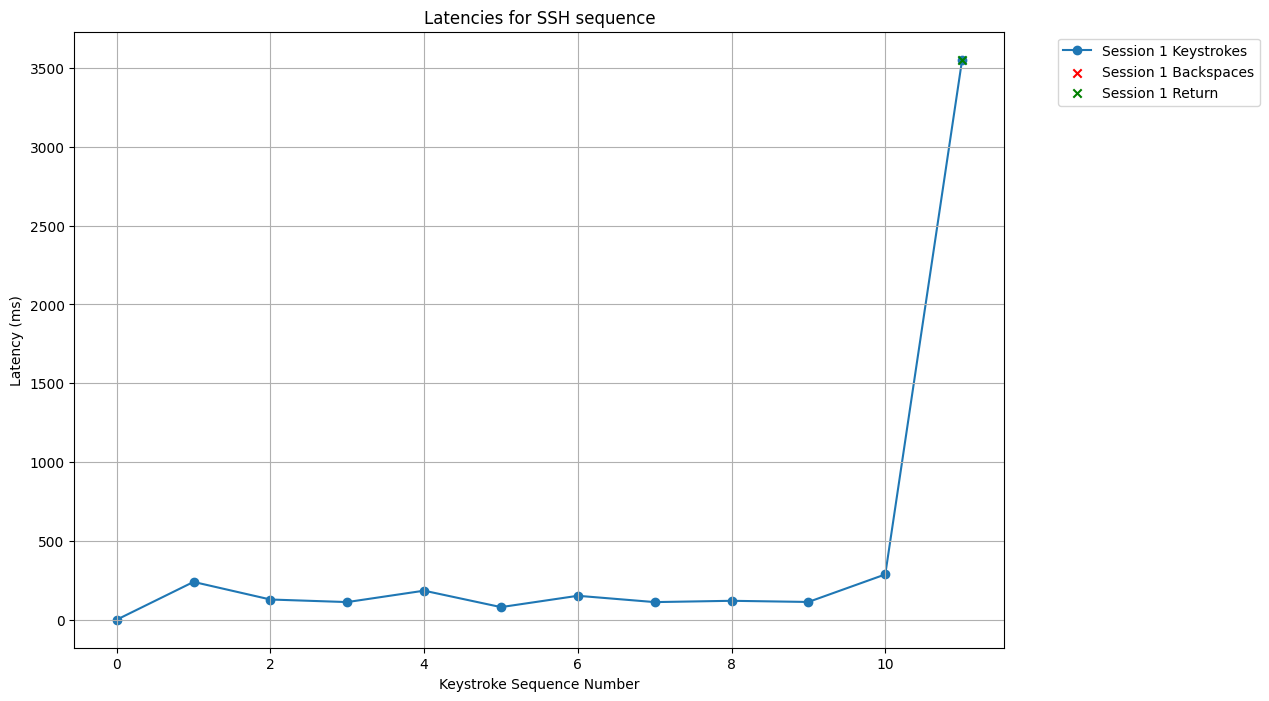

In [373]:
plot_ssh_data(ssh_data[4])

In [374]:
def plot_ssh_data(ssh_sessions):
    plt.figure(figsize=(12, 8))
    
    for sequence_idx, sequence in enumerate(ssh_sessions):
        keystroke_times = [event['timestamp'] for event in sequence if event['k_type'] == 'Keystroke']  # Convert to milliseconds
        enter_times = [event['timestamp'] for event in sequence if event['k_type'] == 'Enter']
        enter_sizes = [event['response_size'] for event in sequence if event['k_type'] == 'Enter']
        
        # Plotting keystrokes
        plt.plot(keystroke_times, [sequence_idx + 1] * len(keystroke_times), 'bo', label='Keystrokes' if sequence_idx == 0 else "")
        
        # Plotting Enter presses
        for enter_time, size in zip(enter_times, enter_sizes):
            plt.plot(enter_time, sequence_idx + 1, 'rx', label='Enter Press' if sequence_idx == 0 else "")
            plt.text(enter_time, sequence_idx + 1, f' {size}B', verticalalignment='bottom')

    plt.yticks(range(1, len(ssh_sessions) + 1), [f'Sequence {i+1}' for i in range(len(ssh_sessions))])
    plt.title('SSH Packet Timestamps and Enter Presses')
    plt.xlabel('Time (ms)')
    plt.ylabel('Sequence Number')
    plt.legend()
    plt.grid(True)
    plt.show()

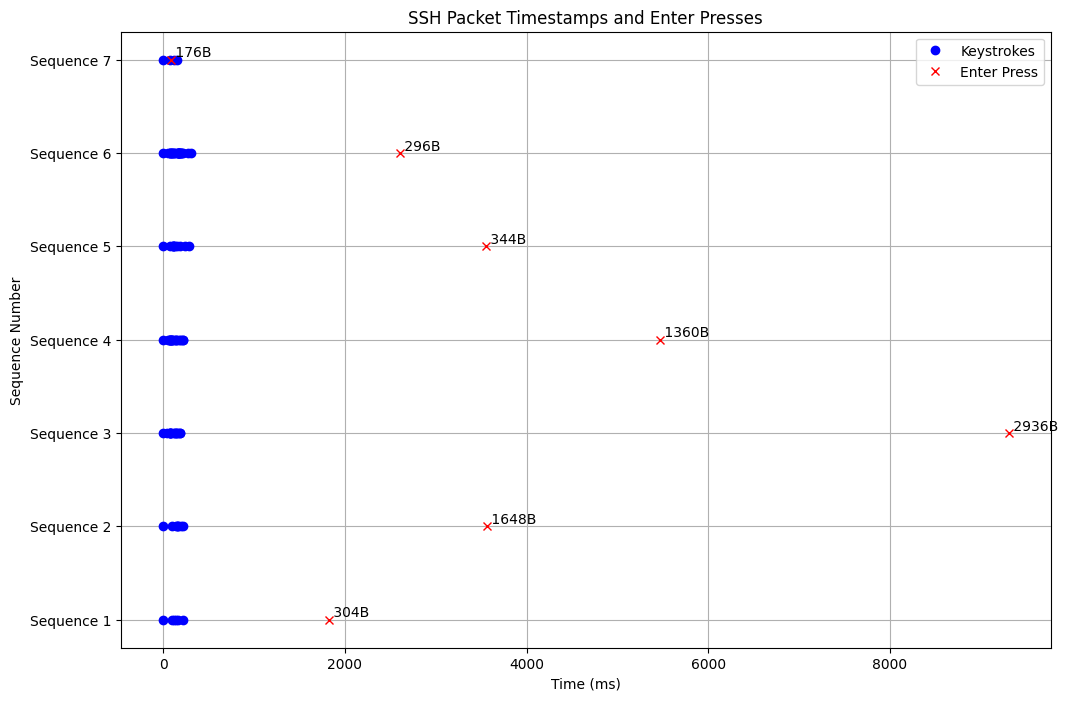

In [375]:
plot_ssh_data(ssh_data)

In [335]:
## Dynamic Time Warping (DTW)

In [376]:
from dtaidistance import dtw
import numpy as np

In [377]:
ssh_data = convert_latencies(load_ssh_data("./sshniff_output/keystrokes.json"))
cmds = get_prepared_data(True)
cmds = handle_backspaces(cmds)
cmds = combine_common_tokens(cmds)

In [378]:
# Remove RETURN from intercept?
for sequence in ssh_data:
    sequence.pop()

In [379]:
# Expects get_mean_latencies('id', cmds['id'])
# Ignores RET, unless command has an extra character at the end.
def get_mean_latencies(command, command_dataset):
    means = [0 for i in range(len(command))]
    for letter_index, letter in enumerate(command):
        for sequence in command_dataset:
            means[letter_index] += sequence[letter_index]['latency']
    means = [i / len(command_dataset) for i in means]
    return np.array(means)

In [380]:
command = "iptables -L"
unlabeled_latencies = np.array([keystroke['timestamp'] for keystroke in ssh_data[4]])
cmd_mean_latencies = get_mean_latencies(command, cmds[command]) 

In [381]:
[keystroke['timestamp'] for keystroke in ssh_data[2]]

[0.0,
 79.973,
 151.947,
 167.776,
 184.25,
 144.38,
 87.696,
 128.233,
 79.999,
 104.02,
 191.915,
 79.751,
 79.902,
 135.933,
 48.148]

In [382]:
cmd_mean_latencies

array([  0.        , 172.18181818,  62.45454545,  72.72727273,
       154.36363636,  80.18181818, 139.09090909,  87.18181818,
       106.81818182,  87.18181818, 232.45454545])

In [383]:
unlabeled_norm = unlabeled_latencies / np.max(unlabeled_latencies)
known_norm = cmd_mean_latencies / np.max(cmd_mean_latencies)
distance = dtw.distance(unlabeled_norm, known_norm)
print("DTW Distance:", distance)

DTW Distance: 0.24139264595530577


In [388]:
def eliminate_candidates(intercept_length, command_dataset):
    """
    Reduces the scope of possible commands.

    Using the intercepted command's length, we can exclude commands with 
    a minimum length longer than the intercept. 
        i.e.: A five-letter intercept (XXXXX) cannot be ifconfig, no matter
        how well the signature might match.
    """
    candidates = {}
    for command in command_dataset.keys():
        splices = command.split(' ')
#        if splices[0] == 'sudo':
#            if len(splices[1]) + 5 > intercept_length:
#                # Ignore command if itself 
#                continue
        if len(splices[0]) > intercept_length:
            # Ignore command if it is longer than the intercepted length.
            # i.e., a five-letter intercept cannot be <ifconfig>, no matter how well it matches.
            continue
        else:
            candidates[command] = command_dataset[command]
    return candidates

In [385]:
def find_best_match(intercepted, command_dataset):
    """
    Creates an ordered list of the distance of all possible commands to an intercepted sequence.

    Distance is calculated using Dynamic Time Warping (DTW). 
    """
    unlabeled_latencies = np.array([keystroke['timestamp'] for keystroke in intercepted])
    unlabeled_norm = unlabeled_latencies / np.max(unlabeled_latencies)

    distances = []
    candidates = eliminate_candidates(len(intercepted), command_dataset)
    for command in candidates.keys():
        try:
            cmd_mean_latencies = get_mean_latencies(command, command_dataset[command])
        except:
            print(f"failed at {command}")
            continue
        known_norm = cmd_mean_latencies / np.max(cmd_mean_latencies)
        distance = dtw.distance(unlabeled_norm, known_norm)
        distances.append((command, distance))

    distances = sorted(distances, key=lambda x: x[1])
    return distances

In [386]:
find_best_match(ssh_data[3], cmds)

[('sudo apt upgrade ', 0.57410781494813),
 ('ping -c 1 9.9.9.9', 0.638267611745968),
 ('ifconfig', 0.7307000728774575),
 ('cat /etc/hosts', 0.7403838809952429),
 ('curl http://', 0.7795780237676415),
 ('iptables -L', 0.7817823847563101),
 ('tar --help', 0.7880689214823248),
 ('cat /etc/resolv.conf', 0.7936981502072052),
 ('systemctl', 0.8043030471932169),
 ('systemctl stop ', 0.8079253702170153),
 ('systemctl status ', 0.8267712297400878),
 ('touch ', 0.8480534614210572),
 ('cat /etc/passwd', 0.8500276724142628),
 ('iptables -S', 0.865134638281377),
 ('wget https://', 0.8664987368072451),
 ('sudo apt update', 0.8701679313553401),
 ('df -hT /', 0.8703338084395944),
 ('rm -rf /tmp/*', 0.8782204900943745),
 ('systemctl restart ', 0.892205146199822),
 ('tail /var/log/syslog', 0.9050254308315562),
 ('systemctl start ', 0.9176605670821919),
 ('mv * ../', 0.9345266490351055),
 ('uptime', 0.9997655825972209),
 ('exit', 1.0078100550645708),
 ('whoami', 1.0350429240855592),
 ('sudo su', 1.039394

In [356]:
sudo = ssh_data[2][:5]

In [357]:
find_best_match(sudo, cmds)

[('sudo', 0.3477635275587289),
 ('rm -rf /tmp/*', 0.3769109701734561),
 ('cd', 0.37794177956394887),
 ('tar --help', 0.3988128583661368),
 ('touch ', 0.43567575781429924),
 ('id', 0.4765795309550633),
 ('sudo su', 0.5266152825897691),
 ('curl http://', 0.5623426298853395),
 ('exit', 0.6313450587666717),
 ('wget https://', 0.6593016162287152),
 ('df -hT /', 0.6899212801101497),
 ('cat /etc/hosts', 0.8358267923331405),
 ('ping -c 1 9.9.9.9', 0.8565467769263311),
 ('tail /var/log/syslog', 0.9465034088496813),
 ('sudo apt upgrade ', 0.9608209146707403),
 ('sudo apt update', 0.980940692820885),
 ('mv * ../', 1.0045429304023148),
 ('cat /etc/passwd', 1.2376833046910585),
 ('cat /etc/resolv.conf', 1.2481967669622207)]

In [2]:
# HMM Stuff

In [45]:
with open("./commands.json", "r") as f:
    commands = json.load(f)

In [46]:
s_cmds = []
for category in commands['commands']:
    s_cmds.extend(category['patterns'])
s_cmds.extend(commands['commonFlags'])
s_cmds.extend(commands['commonPathStarts'])

In [47]:
s_cmds

['ls -l',
 'cd',
 'pwd',
 'touch ',
 'cp file1 file2',
 'mv file1 file2',
 'rm file',
 'mkdir directory',
 'rmdir directory',
 'cat file',
 'less file',
 'nano file',
 'vim file',
 'chmod +x file',
 'chown user:group file',
 'sudo command',
 'su - user',
 'whoami',
 'man command',
 "echo 'text'",
 'head ',
 'tail -f ',
 'exit',
 'ps -aux',
 'top',
 'htop',
 'kill pid',
 'df -h',
 'du -h directory',
 'uname -a',
 'uptime',
 'free -m',
 'vmstat',
 'iostat',
 'systemctl status service',
 'service name start',
 'ping host',
 'netstat -tuln',
 'ss -tuln',
 'curl https://example.com',
 'wget https://example.com',
 'scp file user@host:path',
 'ssh user@host',
 'iptables -L',
 'ufw enable',
 'ip addr',
 'apt-get update',
 'apt-get install package',
 'dpkg -i package.deb',
 'yum install package',
 'dnf install package',
 'pacman -Syu',
 'pacman -S package',
 "grep -i 'pattern' file",
 "awk '/pattern/ {action}' file",
 "sed 's/find/replace/' file",
 'sort file',
 'uniq file',
 'tar -czvf archive

In [48]:
char_pairs = set()

for cmd in s_cmds:
    for i in range(len(cmd) - 1):
        pair = cmd[i:i+2]
        char_pairs.add(pair)

In [49]:
char_pairs

{" '",
 ' +',
 ' -',
 ' a',
 ' b',
 ' c',
 ' d',
 ' e',
 ' f',
 ' h',
 ' i',
 ' n',
 ' o',
 ' p',
 ' s',
 ' u',
 ' {',
 "' ",
 "'/",
 "'p",
 "'s",
 "'t",
 '+x',
 '- ',
 '--',
 '-L',
 '-S',
 '-a',
 '-c',
 '-f',
 '-g',
 '-h',
 '-i',
 '-l',
 '-m',
 '-t',
 '-v',
 '..',
 './',
 '.c',
 '.d',
 '.g',
 '.p',
 '.t',
 '.z',
 '/ ',
 "/'",
 '//',
 '/d',
 '/e',
 '/f',
 '/p',
 '/r',
 '/z',
 '1 ',
 '10',
 '1M',
 '3 ',
 ':/',
 ':g',
 ':p',
 '=/',
 '=1',
 '=f',
 '@h',
 'M ',
 'S ',
 'Sy',
 'ab',
 'ac',
 'ad',
 'ag',
 'ai',
 'al',
 'am',
 'an',
 'ap',
 'ar',
 'at',
 'au',
 'aw',
 'bl',
 'bs',
 'ca',
 'cd',
 'ce',
 'ch',
 'ck',
 'cm',
 'co',
 'cp',
 'cr',
 'ct',
 'cu',
 'cz',
 'd ',
 'd/',
 'da',
 'dd',
 'de',
 'df',
 'di',
 'dn',
 'do',
 'dp',
 'dr',
 'du',
 'e ',
 'e.',
 'e/',
 'e1',
 'e2',
 'ea',
 'eb',
 'ec',
 'ed',
 'ee',
 'el',
 'em',
 'en',
 'ep',
 'er',
 'es',
 'et',
 'ev',
 'ex',
 'f ',
 'f=',
 'fi',
 'fr',
 'fw',
 'g ',
 'ge',
 'gr',
 'gz',
 'h ',
 'he',
 'hi',
 'hm',
 'ho',
 'ht',
 'i ',
 'ic',

In [50]:
len(char_pairs)

296

In [138]:
def get_minlen(command: str) -> int:
    # How do we reliably determine minimum length?
    # Split at first ' ' doesn't cover cmds like 'cp src dst' but it is a start.
    splice = command.split(" ", 1)[0]
    return len(splice)

In [139]:
def get_charpairs(command: str) -> (str, set()):
    if len(command) < 2:
        return
    first = set([command[:2]])
    rest = set()
    for i in range(1, len(command)-1):
        rest.add(command[i:i+2])
    return [first, rest]

In [147]:
# This one doesn't make much sense. Each start state can only logically produce certain following states, so it doesn't make sense to pool them by length
def make_state_objects(commands: list):
    # minlen -> (startstates, states)?
    state_objects = {}
    # (minlen, startstate, states)
    for command in commands:
        minlen = get_minlen(command)
        pairs = get_charpairs(command)
        if not pairs:
            continue
        if minlen in state_objects:
            state_objects[minlen][0] = state_objects[minlen][0].union(pairs[0])
            state_objects[minlen][1] = state_objects[minlen][1].union(pairs[1])
        else:
            state_objects[minlen] = pairs
    return state_objects

In [175]:
def get_pairs(command: str):
    pairs = []
    for i in range(len(command) - 1):
        pair = command[i:i+2]
        pairs.append(pair)
    return pairs

In [188]:
def make_len_map(commands: list):
    # minlen -> [["if", "fc", "co", "on", "nf", "fi", "ig"], ...]
    lenmap = {}
    for command in commands:
        minlen = get_minlen(command)
        pairs = get_pairs(command)
        if not pairs:
            continue
        if minlen in lenmap:
            lenmap[minlen].append(pairs)
        else:
            lenmap[minlen] = [pairs]
    return lenmap

In [189]:
mp = make_len_map(s_cmds)

In [193]:
mp[5]

[['to', 'ou', 'uc', 'ch', 'h '],
 ['mk',
  'kd',
  'di',
  'ir',
  'r ',
  ' d',
  'di',
  'ir',
  're',
  'ec',
  'ct',
  'to',
  'or',
  'ry'],
 ['rm',
  'md',
  'di',
  'ir',
  'r ',
  ' d',
  'di',
  'ir',
  're',
  'ec',
  'ct',
  'to',
  'or',
  'ry'],
 ['ch', 'hm', 'mo', 'od', 'd ', ' +', '+x', 'x ', ' f', 'fi', 'il', 'le'],
 ['ch',
  'ho',
  'ow',
  'wn',
  'n ',
  ' u',
  'us',
  'se',
  'er',
  'r:',
  ':g',
  'gr',
  'ro',
  'ou',
  'up',
  'p ',
  ' f',
  'fi',
  'il',
  'le'],
 ['un', 'na', 'am', 'me', 'e ', ' -', '-a'],
 ['un',
  'nz',
  'zi',
  'ip',
  'p ',
  ' a',
  'ar',
  'rc',
  'ch',
  'hi',
  'iv',
  've',
  'e.',
  '.z',
  'zi',
  'ip']]